# Data Analysis and Outlier Identification for DIY IoT Hydrometer

This Jupyter Notebook focuses on analyzing the data obtained from a DIY IoT Hydrometer setup as explained in [this blog post](https://codebeats.ml/blogpost/chatgpt-shocked-me-with-its-lightning-fast-understanding-of-my-beer-fermentation-thesis). The setup involves using a regular hydrometer in the fermentation tank and a distance sensor placed on top of the tank to measure how the hydrometer gradually sinks in proportion to the change in the wort's specific gravity and alcohol content of the beer. The data collected by the distance sensor is used to create a time series that tracks the alcohol production during the fermentation process. 

The notebook will also cover outlier identification through the use of an Isolation Forest machine learning algorithm, providing insight into any anomalies in the data and helping ensure the accuracy of the alcohol content measurements.

## Loading the data

To get started, the data is loaded into a Pandas DataFrame, and is filtered to only include readings taken before a certain date using a conditional statement.

Next, a rolling mean of the latest 20 hydrometer readings is calculated using the rolling function from Pandas. This helps to smooth out any fluctuations in the data, making it easier to identify trends. 

We make adjustments to various visualization settings, including the font size of key graph elements and the overall theme of our plots.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import seaborn as sns

# Define fonts to use on Matplotlib plots.
TitleFont = fm.FontProperties(fname='Quicksand-Bold.otf', size=25)
AxisFont = TitleFont
TicksFont = fm.FontProperties(fname='Quicksand-Regular.otf', size=15)

# Load Hydrometer readings to a Pandas DataFrame.
df = pd.read_csv("hydro.csv")
df = df[df['Measurement taken on'] < '2020-10-14T16:33:40+00:00']

# Define helper column mto that will be used later by the Isolation Forest algorithm.
df['mto'] = df['Measurement taken on']
df['Measurement taken on'] = pd.to_datetime(df['Measurement taken on'])
df['mto'] = pd.to_datetime(df['mto'])
df.set_index('Measurement taken on', inplace=True)

# Calculate the rolling mean of the latest 20 hydrometer readings.
rolling_mean = df.rolling(window=20).mean()

# Set SNS theme and style, as well as font size for each element.
sns.set_theme()
sns.set_style('white') # darkgrid, white grid, dark, white and ticks

plt.rc('axes', titlesize=60)     # fontsize of the axes title
plt.rc('axes', labelsize=40)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

## Plotting the data

Let's now plot and visualize the data. well plot both the hydrometer readings and the rolling mean of the latest 20 readings.

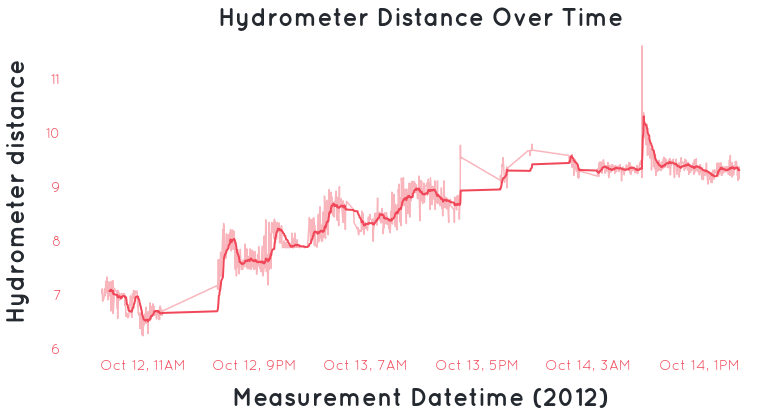

In [13]:
# Create a subplot with specified figure size
fig, ax = plt.subplots(figsize=(11, 6))

# Plot the line chart of hydrometer distance over time
sns.lineplot(x='Measurement taken on', y='Hydrometer distance', data=df, ax=ax, linewidth=1.5, color="#f04859", alpha=0.4)

# Plot the daily mean with a label of "Daily Mean", line width of 2, and color of "#f04859"
plt.plot(rolling_mean, label="Daily Mean", color="#f04859",linewidth=2)

# Set the title of the subplot, using the specified font and color
ax.set_title("Hydrometer Distance Over Time", weight="bold", fontproperties=TitleFont, color="#242930")

# Set the x-axis label with specified padding, weight, font, and color
ax.set_xlabel("Measurement Datetime (2012)", labelpad=15, weight="bold", fontproperties=AxisFont, color="#242930")

# Set the y-axis label with specified padding, weight, font, and color
ax.set_ylabel("Hydrometer distance", labelpad=15, weight="bold", fontproperties=AxisFont, color="#242930")

# Hide all axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Define the format of the x-axis tick labels
fmt = mdates.DateFormatter('%b %d, %-I%p')

# Define the x-axis tick locator with an interval of 10 hours
hours = mdates.HourLocator(interval = 10)

# Set the major locator and formatter of the x-axis
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(fmt)

# Loop through the x-axis tick labels and set their font properties and color
for label in ax.get_xticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#f04859")

# Loop through the y-axis tick labels and set their font properties and color
for label in ax.get_yticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#f04859")
    
plt.tight_layout()

# Anomaly Detection with Isolation Forests

Let's now use an Isolation Forest to detect anomalies in our dataset. The Isolation Forest will be trained with the hydrometer distance and datetime values. 

Finally, we used the fit_predict method to make predictions about which data points are anomalies, and add a new column "anomaly" to indicate whether a data point is an anomaly or not.

In [14]:
# Import the IsolationForest module from scikit-learn's ensemble library
from sklearn.ensemble import IsolationForest

# Create a new column in the dataframe called 'hour' that contains the hour from the datetime column 'mto'
df['hour'] =  df['mto'].dt.hour.map(str)

# Create a new column in the dataframe called 'datetime' that combines the day and hour columns, with the hour zero-padded to two digits
df['datetime'] = df['mto'].dt.day.map(str)+df['hour'].str.zfill(2)

# Initialize an IsolationForest model with the following parameters:
# n_estimators: the number of trees in the forest, set to 100
# max_samples: the number of samples to draw from the data, set to 'auto'
# max_features: the number of features to draw from the data, set to 2
# n_jobs: the number of parallel jobs to run, set to -1 (all available cores)
# random_state: the random number generator seed, set to 2
# contamination: the expected proportion of outliers in the data, set to 0.1
# bootstrap: whether to bootstrap the samples or not, set to True
iforest = IsolationForest(n_estimators=100, max_samples='auto',  max_features=2, n_jobs=-1, random_state=2, contamination=0.1, bootstrap=True)

# Fit the model to the data and predict the anomalies
pred = iforest.fit_predict(df[['Hydrometer distance', 'datetime']].values)

# Create a new column in the dataframe called 'anomaly' that contains the predictions from the IsolationForest model
df['anomaly']=pred

We finally plot all the sensor readings while highlighting the identified anomalies.

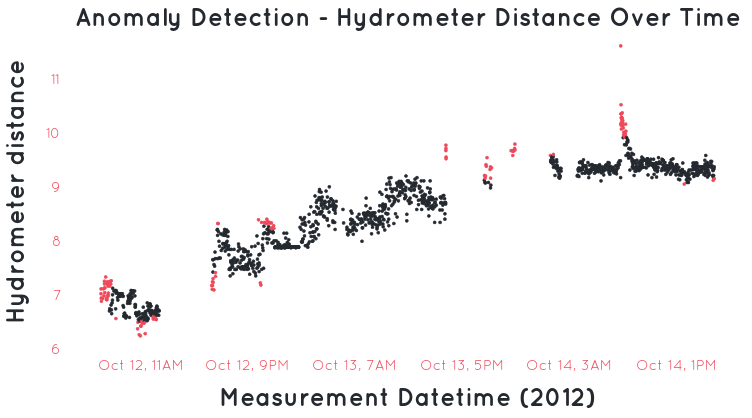

In [15]:
fig, ax = plt.subplots(figsize=(11, 6))

sns.scatterplot(x='Measurement taken on', y='Hydrometer distance', data=df, ax=ax, linewidth=0.5, marker='.', color="#f04859", hue="anomaly", edgecolor=None, palette=['#f04859', '#242930'])

ax.set_title("Anomaly Detection - Hydrometer Distance Over Time", weight="bold", fontproperties=TitleFont, color="#242930")
ax.set_xlabel("Measurement Datetime (2012)", labelpad=15, weight="bold", fontproperties=AxisFont, color="#242930")
ax.set_ylabel("Hydrometer distance", labelpad=15, weight="bold", fontproperties=AxisFont, color="#242930")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fmt = mdates.DateFormatter('%b %d, %-I%p')
hours = mdates.HourLocator(interval = 10)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(fmt)

for label in ax.get_xticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#f04859")
for label in ax.get_yticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#f04859")

plt.legend([],[], frameon=False)

plt.tight_layout()